In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get the device
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    device = torch.cuda.current_device() 
else:
    device = 'cpu'
print(device)

0


In [3]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
print(f'Total names: {len(words)}')
print(f'Maximum length: {max(len(w) for w in words)}')
print(f'{words[:8]}')

Total names: 32033
Maximum length: 15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
# print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def split_dataset(words, bz):  
  """ split the dataset into training, validating and testing. """
  
  X, Y = [], []
  
  for w in words:
    context = [0] * bz
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)
  print(X.shape, Y.shape)
  return X, Y

In [8]:
block_size = 3 # context length: how many characters do we take to predict the next one?

In [9]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = split_dataset(words[:n1], block_size)     # 80% training
Xdev, Ydev = split_dataset(words[n1:n2], block_size)   # 10% validating
Xte,  Yte  = split_dataset(words[n2:], block_size)     # 10% testing

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [12]:
print(f'training samples inputs: {Xtr[10:15]}')
print(f'training samples outputs: {Ytr[10:15]}')

training samples inputs: tensor([[19, 21, 12],
        [21, 12,  5],
        [12,  5, 13],
        [ 5, 13,  1],
        [13,  1, 14]], device='cuda:0')
training samples outputs: tensor([ 5, 13,  1, 14,  0], device='cuda:0')


In [37]:
def cmp_grad(s, dt, t):
    """ Compare manual gradients to Pytorch gradient
    
    params:
        s: name of item for comparison
        dt: the manual computational gradient
        t: the gradient obtained by pytorch gradient 
    """
    ex = torch.all(dt == t.grad).item() # Compare the gradient computed by torch
    app = torch.allclose(dt, t.grad)    # Compare the approximation gradient (floating point number issu)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff : {maxdiff}')

In [14]:
# The model with two layers and an embedding layer
# Embedding layer will encode [1, block_size] to [n_embd, block_size]

n_embd = 10     # the dimensionality of the character embedding vectors
n_hidden = 64   # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

In [21]:
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'Total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

Total parameters: 4137


In [22]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [24]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

In [25]:
# Gradient obtained by Pytorch backward()
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.5122, grad_fn=<NegBackward0>)

In [36]:
# The first step is to compute derivate of logprobs w.r.t the loss function 
# loss = -logprobs[range(n), Yb].mean()

logprobs[range(batch_size), Yb] # Pick column values based on items in Yb from logprobs

# An math example
# loss = (a + b + c) / 3 = 1/3a + 1/3b + 1/3c
# dloss/da = 1 / 3 => dloss/da = 1/n, where n is the number of all elements 

# Since logprobs is an 2d array, but only selected elements participate in gradient computation
# those unselected elements are set to be 0, since they don't participate in gradient computation
# and those selected position are set by 1/n, since the derivated of mean := 1/n 
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n 
cmp_grad("logprobs", dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff : 0.0


In [38]:
# The second step is to compute derivate of probs w.r.t logprobs 
# logprobs = probs.log()
# which is 1.0 / x
dprobs = (1.0 / probs) * dlogprobs # By chain rule
cmp_grad("probs", dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff : 0.0


In [43]:
# The third step is to compute derivate of counts_sum_inv w.r.t probs 
# there is an boardcase during the counts * counts_sum_inv
# column in counts_sum_inv should be replicated 27 times to finish the element wise multiplication
# c = a * b but with tensor
print(f'counts shape: {counts.shape}, counts_sum_inv shape: {counts_sum_inv.shape}')

# a[3x3] * b[3x1] =>
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# Thus b1, b2, and b3 have been used for multiple time, the gradient has to be sum up along all three elements

# Then dcounts_sum_inv has to be sum up along the row 
# just like sum up the gradient in a node that mulitple branches cross in the computational graph 
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)

cmp_grad("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)

counts shape: torch.Size([32, 27]), counts_sum_inv shape: torch.Size([32, 1])
counts_sum_inv  | exact: True  | approximate: True  | maxdiff : 0.0


In [44]:
# The forth step is to compute derivate of counts_sum w.r.t counts_sum_inv 
dcounts_sum = -counts_sum ** -2 * dcounts_sum_inv
cmp_grad("counts_sum", dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff : 0.0


In [48]:
# The fifth step is to compute derivate of counts w.r.t counts_sum
# there are two branches that contribute to the gradient of counts
# the first is the counts_sum_inv, the second is counts_sum
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
cmp_grad("counts", dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff : 0.0


In [50]:
# The sixth step is to compute the derivate of norm_logits w.r.t counts
dnorm_logits = norm_logits.exp() * dcounts
cmp_grad("norm_logits", dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff : 0.0


In [53]:
# The seventh step is to compute the derivate of logits_maxex w.r.t norm_logits
print(norm_logits.shape, logits.shape, logit_maxes.shape)
# Notice that the boardcasting is also needed in this process
# thus sum up all replicated columns in the gradient computation
dlogits_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
cmp_grad("logit_maxes", dlogits_maxes, logit_maxes)

torch.Size([32, 27]) torch.Size([32, 27]) torch.Size([32, 1])
logit_maxes     | exact: True  | approximate: True  | maxdiff : 0.0


logits          | exact: True  | approximate: True  | maxdiff : 0.0


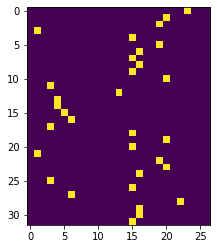

In [55]:
# The eighth step is to compute the derivate of logits w.r.t norm_logits
dlogits = dnorm_logits.clone()
plt.imshow(F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]))
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogits_maxes
cmp_grad("logits" ,dlogits, logits)

In [ ]:
# 